In [1]:
# importing libraries
from time import time
import multiprocessing
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from glob import glob
import skimage
import torch
import SimpleITK as sitk
import skimage, torch, torchvision
import torchxrayvision as xrv
import torchvision
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import sys
import warnings
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
import random
import logging
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve,auc,accuracy_score,classification_report,confusion_matrix
import tensorflow as tf
from keras.models import load_model
from tensorflow import keras
from sklearn.model_selection import train_test_split

2023-10-14 23:14:58.196731: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def AUC_ROC_Binary(y_true,y_score):
    y_true=y_true.reshape((-1,1))
    y_score=y_score.reshape((-1,1))
    fpr, tpr, thresholds = roc_curve(y_true, y_score,pos_label=1)
    score_value = roc_auc_score(y_true=y_true, y_score=y_score)
    plt.figure(dpi=150)
    plt.plot(fpr, tpr,label="White vs African-American/Asian \n (AUC={:.2f})".format(score_value))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('AUC-ROC for the Prediction of Binary Race (White:P vs non-White:N)')
    plt.plot(y_score,y_score,'--k')
    plt.grid(which='both')
    plt.legend()
    plt.show()

def AUC_Precision_Recall(y_true,y_score):
    y_true=y_true.reshape((-1,1))
    y_score=y_score.reshape((-1,1))
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    plt.figure(dpi=150)
    auc_score = auc(y=precision, x=recall)
    # ,label="White vs African-American/Asian \n (AUC={:.2f})".format(score_value)
    plt.plot(recall[::10],precision[::10],label="White vs African-American/Asian \n (precision-recall AUC={:.2f})".format(auc_score))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('AUC-ROC for the Prediction of Binary Race (White:P vs non-White:N)')
    plt.grid(which='both')
    plt.legend()
    plt.show()

def prob2categ(y_true,y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    gmeans = np.sqrt(tpr * (1-fpr))
    return gmeans[np.argmax(gmeans)]



339/339 [==============================] - 0s 1ms/step


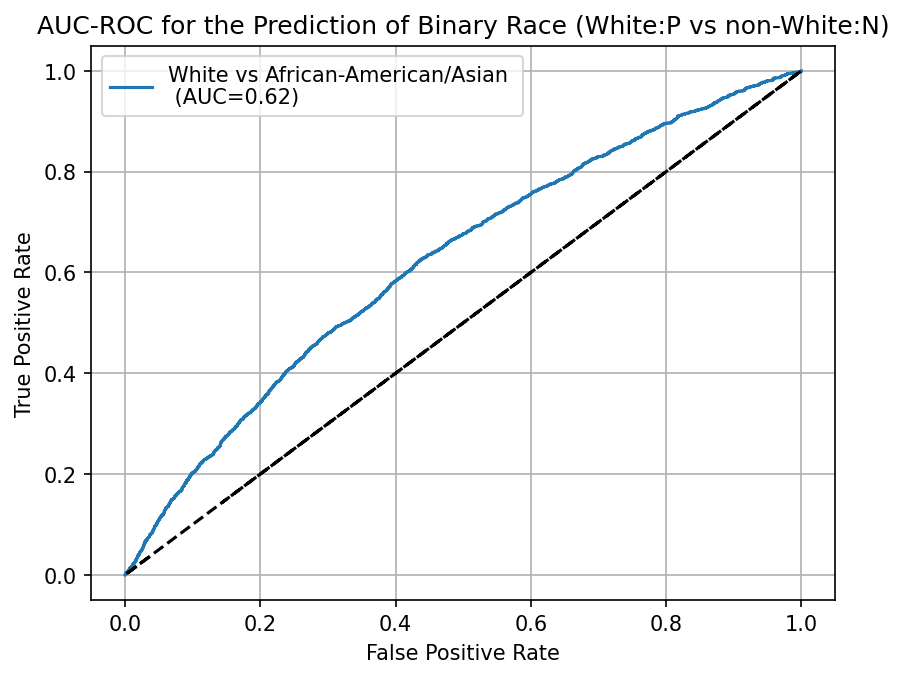

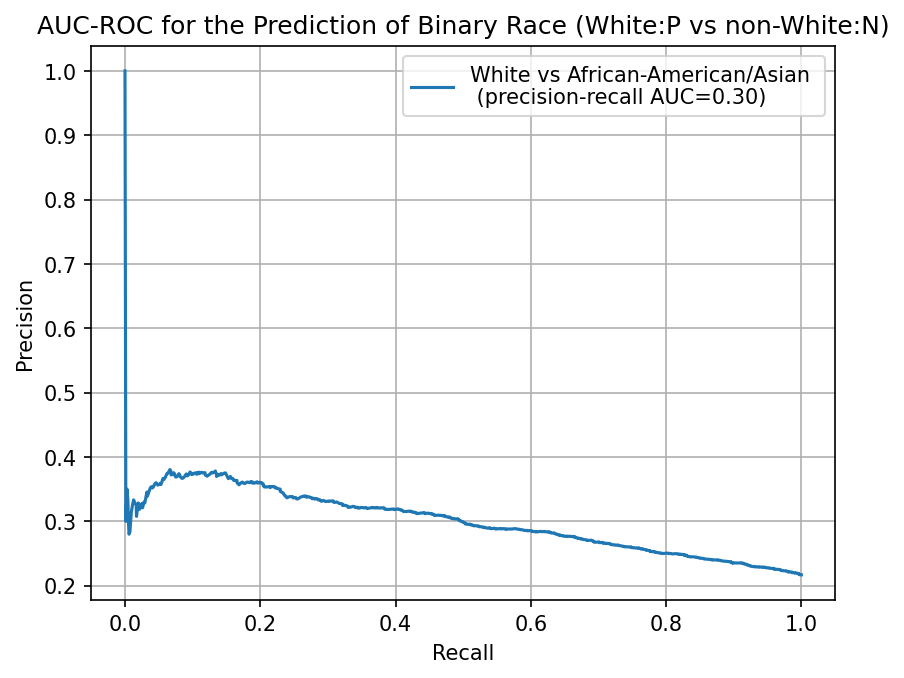

The optimum Threshold is: 0.59
              precision    recall  f1-score   support

         0.0       0.80      0.93      0.86      8484
         1.0       0.37      0.14      0.20      2349

    accuracy                           0.76     10833
   macro avg       0.58      0.54      0.53     10833
weighted avg       0.71      0.76      0.72     10833

[[7927  557]
 [2018  331]]


In [4]:
# chexpert age ful model eevaluated by NIH
name = 'chexpert_race_2_categ_full_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_race_full_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))
y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])

AUC_ROC_Binary(y_true=y_chex_total,y_score=y_predict_chex_total)
AUC_Precision_Recall(y_true=y_chex_total,y_score=y_predict_chex_total)
threshold = prob2categ(y_chex_total,y_predict_chex_total)
print('The optimum Threshold is: {:.2f}'.format(threshold))
class_pred = y_predict_chex_total.copy()
class_pred[class_pred>threshold]=1
class_pred[class_pred<=threshold]=0
print(classification_report(y_true=y_chex_total, y_pred=class_pred))
cm = confusion_matrix(y_true=y_chex_total, y_pred=class_pred)
print(cm)


339/339 [==============================] - 0s 904us/step


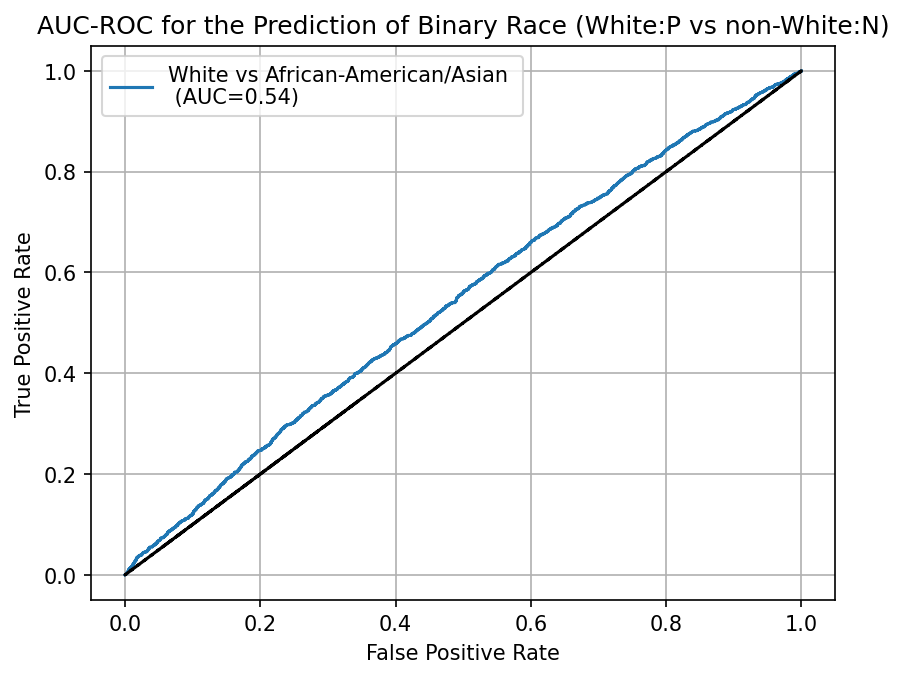

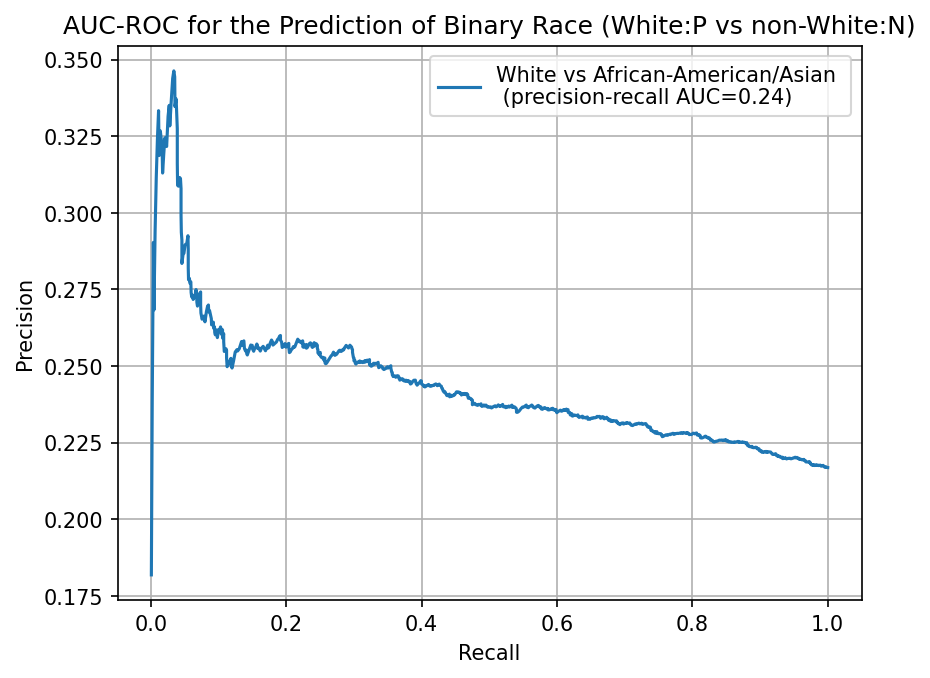

The optimum Threshold is: 0.53
              precision    recall  f1-score   support

         0.0       0.79      0.91      0.84      8484
         1.0       0.26      0.11      0.15      2349

    accuracy                           0.74     10833
   macro avg       0.52      0.51      0.50     10833
weighted avg       0.67      0.74      0.69     10833

[[7724  760]
 [2088  261]]


In [5]:
# chexpert age ful model eevaluated by NIH
name = 'chexpert_race_2_categ_segment_segment_0__'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_race__segment_0__belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))
y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])

AUC_ROC_Binary(y_true=y_chex_total,y_score=y_predict_chex_total)
AUC_Precision_Recall(y_true=y_chex_total,y_score=y_predict_chex_total)
threshold = prob2categ(y_chex_total,y_predict_chex_total)
print('The optimum Threshold is: {:.2f}'.format(threshold))
class_pred = y_predict_chex_total.copy()
class_pred[class_pred>threshold]=1
class_pred[class_pred<=threshold]=0
print(classification_report(y_true=y_chex_total, y_pred=class_pred))
cm = confusion_matrix(y_true=y_chex_total, y_pred=class_pred)
print(cm)

339/339 [==============================] - 0s 829us/step


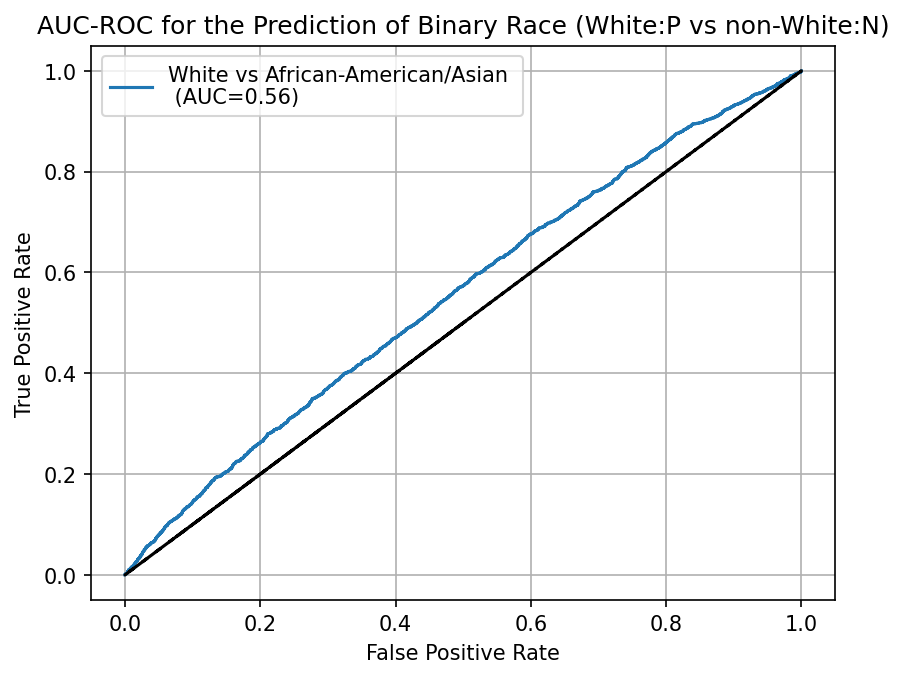

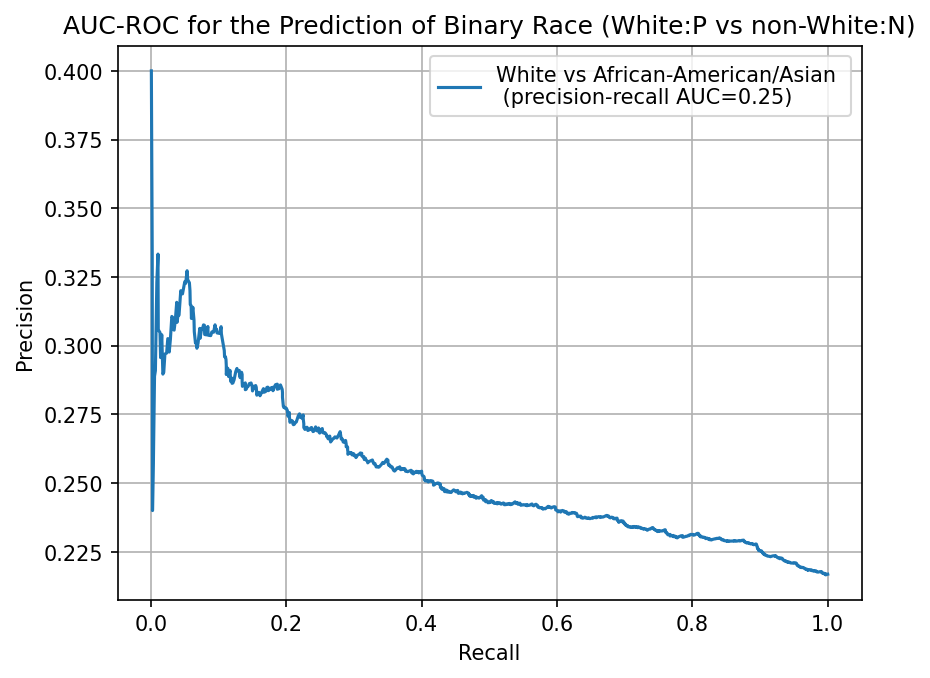

The optimum Threshold is: 0.54
              precision    recall  f1-score   support

         0.0       0.79      0.96      0.86      8484
         1.0       0.30      0.06      0.11      2349

    accuracy                           0.77     10833
   macro avg       0.55      0.51      0.49     10833
weighted avg       0.68      0.77      0.70     10833

[[8138  346]
 [2198  151]]


In [6]:
# chexpert age ful model eevaluated by NIH
name = 'chexpert_race_2_categ_segment_segment_1__'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_race__segment_1__belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))
y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])

AUC_ROC_Binary(y_true=y_chex_total,y_score=y_predict_chex_total)
AUC_Precision_Recall(y_true=y_chex_total,y_score=y_predict_chex_total)
threshold = prob2categ(y_chex_total,y_predict_chex_total)
print('The optimum Threshold is: {:.2f}'.format(threshold))
class_pred = y_predict_chex_total.copy()
class_pred[class_pred>threshold]=1
class_pred[class_pred<=threshold]=0
print(classification_report(y_true=y_chex_total, y_pred=class_pred))
cm = confusion_matrix(y_true=y_chex_total, y_pred=class_pred)
print(cm)

339/339 [==============================] - 0s 836us/step


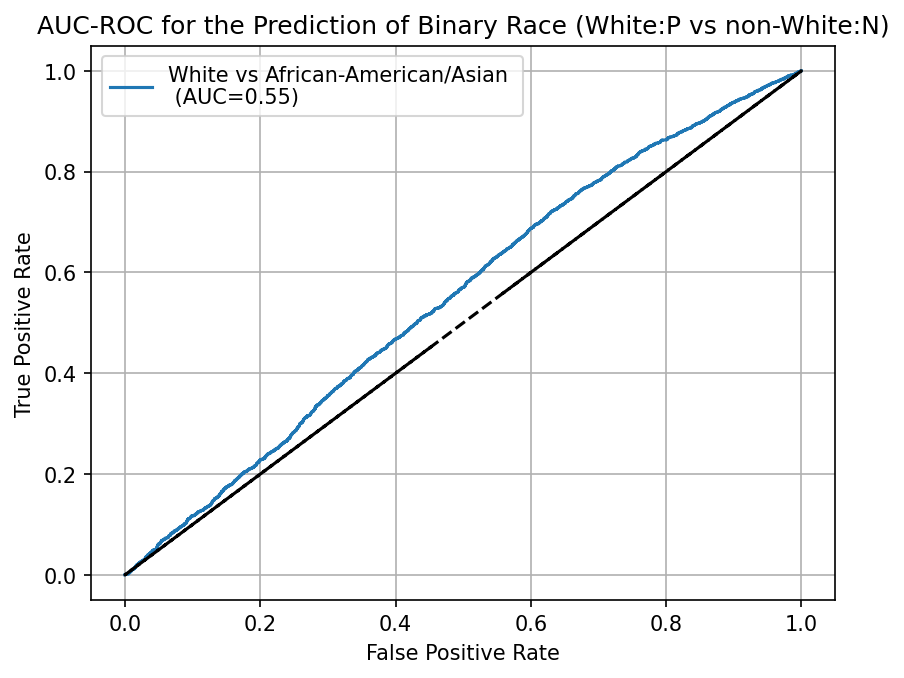

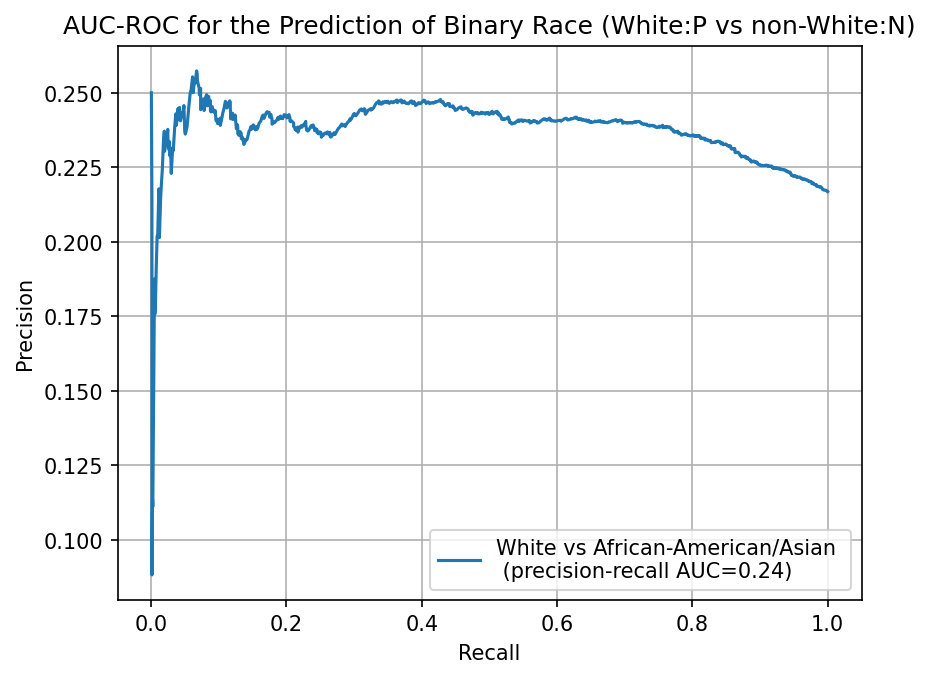

The optimum Threshold is: 0.54
              precision    recall  f1-score   support

         0.0       0.79      0.93      0.85      8484
         1.0       0.25      0.09      0.13      2349

    accuracy                           0.74     10833
   macro avg       0.52      0.51      0.49     10833
weighted avg       0.67      0.74      0.69     10833

[[7860  624]
 [2144  205]]


In [7]:
# chexpert age ful model eevaluated by NIH
name = 'chexpert_race_2_categ_segment_segment_2__'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_race__segment_2__belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))
y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])

AUC_ROC_Binary(y_true=y_chex_total,y_score=y_predict_chex_total)
AUC_Precision_Recall(y_true=y_chex_total,y_score=y_predict_chex_total)
threshold = prob2categ(y_chex_total,y_predict_chex_total)
print('The optimum Threshold is: {:.2f}'.format(threshold))
class_pred = y_predict_chex_total.copy()
class_pred[class_pred>threshold]=1
class_pred[class_pred<=threshold]=0
print(classification_report(y_true=y_chex_total, y_pred=class_pred))
cm = confusion_matrix(y_true=y_chex_total, y_pred=class_pred)
print(cm)

339/339 [==============================] - 0s 979us/step


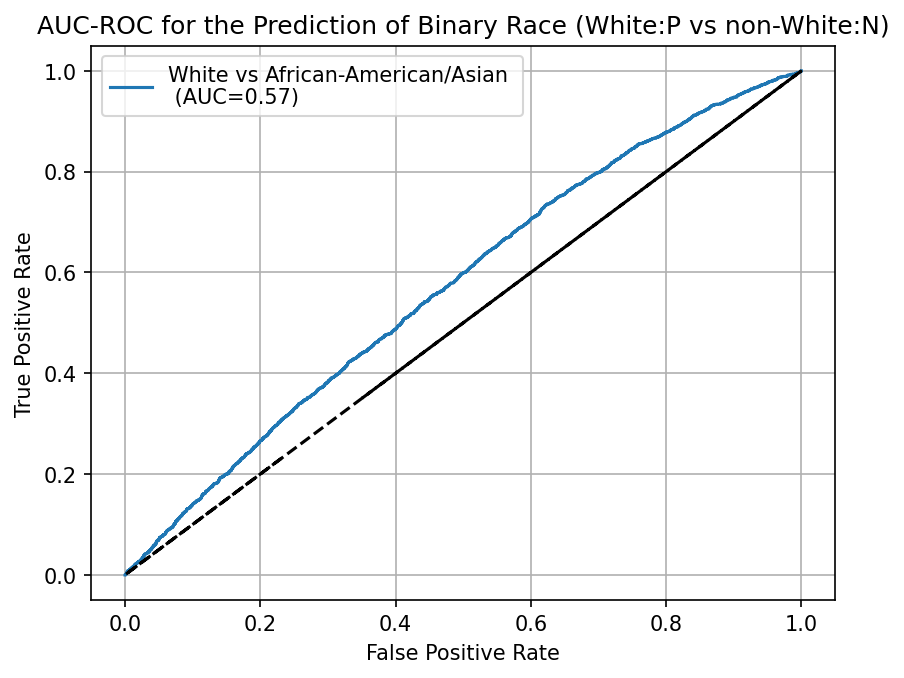

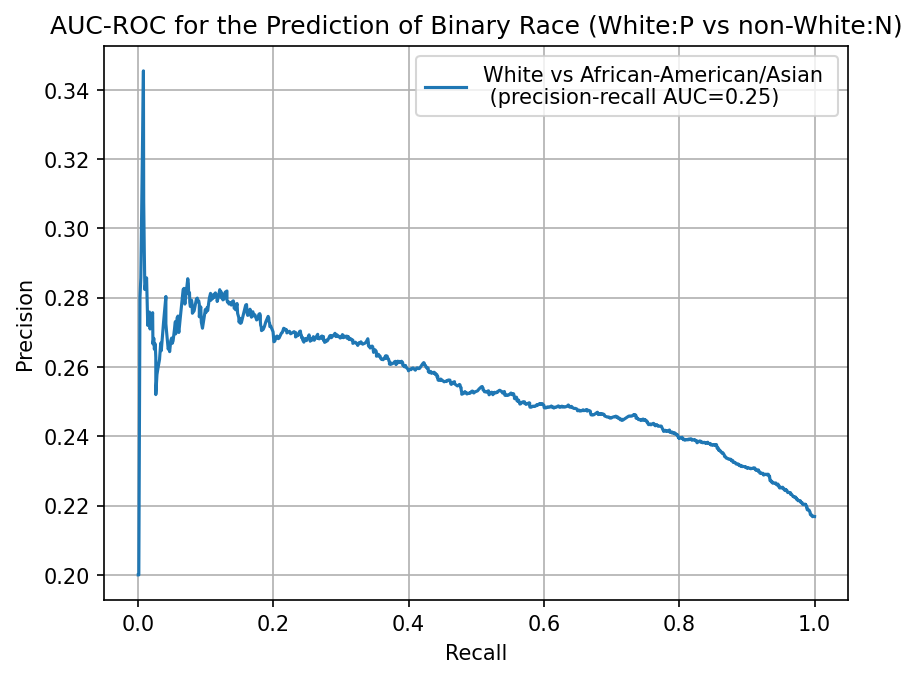

The optimum Threshold is: 0.55
              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85      8484
         1.0       0.28      0.11      0.16      2349

    accuracy                           0.74     10833
   macro avg       0.53      0.52      0.51     10833
weighted avg       0.68      0.74      0.70     10833

[[7801  683]
 [2083  266]]


In [8]:
# chexpert age ful model eevaluated by NIH
name = 'chexpert_race_2_categ_segment_segment_3__'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_race__segment_3__belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))
y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])

AUC_ROC_Binary(y_true=y_chex_total,y_score=y_predict_chex_total)
AUC_Precision_Recall(y_true=y_chex_total,y_score=y_predict_chex_total)
threshold = prob2categ(y_chex_total,y_predict_chex_total)
print('The optimum Threshold is: {:.2f}'.format(threshold))
class_pred = y_predict_chex_total.copy()
class_pred[class_pred>threshold]=1
class_pred[class_pred<=threshold]=0
print(classification_report(y_true=y_chex_total, y_pred=class_pred))
cm = confusion_matrix(y_true=y_chex_total, y_pred=class_pred)
print(cm)

339/339 [==============================] - 0s 986us/step


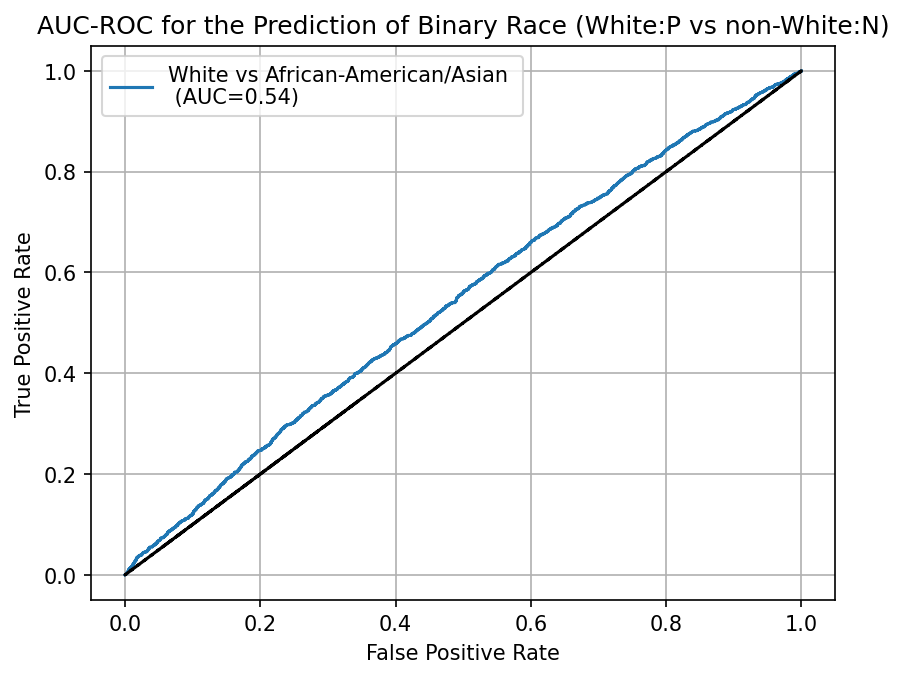

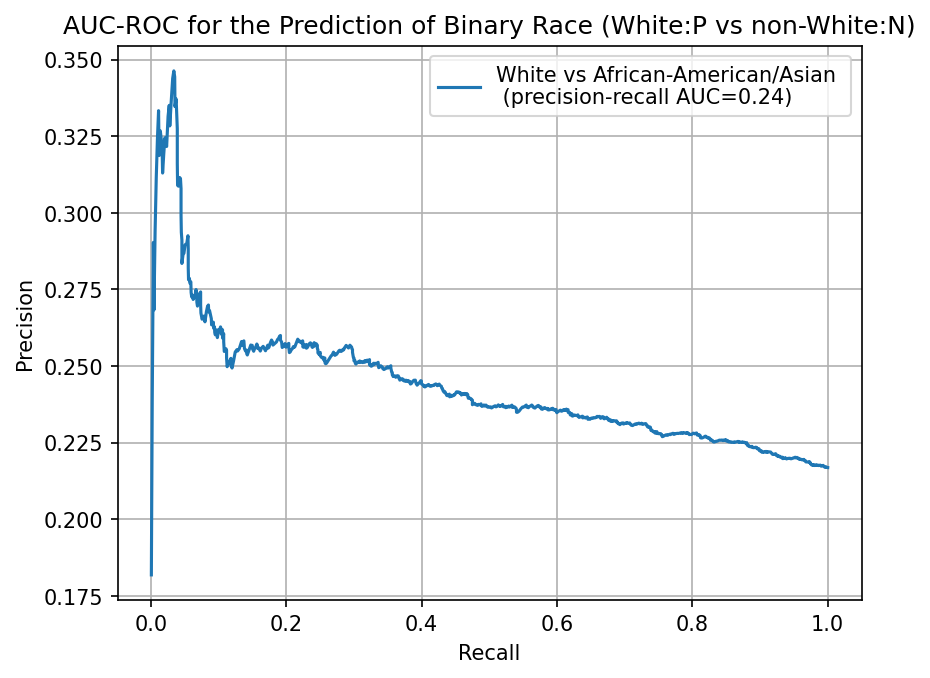

The optimum Threshold is: 0.53
              precision    recall  f1-score   support

         0.0       0.79      0.91      0.84      8484
         1.0       0.26      0.11      0.15      2349

    accuracy                           0.74     10833
   macro avg       0.52      0.51      0.50     10833
weighted avg       0.67      0.74      0.69     10833

[[7724  760]
 [2088  261]]


In [9]:
# chexpert age ful model eevaluated by NIH
name = 'chexpert_race_2_categ_segment_segment_0__'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_race__segment_0__belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))
y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])

AUC_ROC_Binary(y_true=y_chex_total,y_score=y_predict_chex_total)
AUC_Precision_Recall(y_true=y_chex_total,y_score=y_predict_chex_total)
threshold = prob2categ(y_chex_total,y_predict_chex_total)
print('The optimum Threshold is: {:.2f}'.format(threshold))
class_pred = y_predict_chex_total.copy()
class_pred[class_pred>threshold]=1
class_pred[class_pred<=threshold]=0
print(classification_report(y_true=y_chex_total, y_pred=class_pred))
cm = confusion_matrix(y_true=y_chex_total, y_pred=class_pred)
print(cm)

339/339 [==============================] - 0s 856us/step


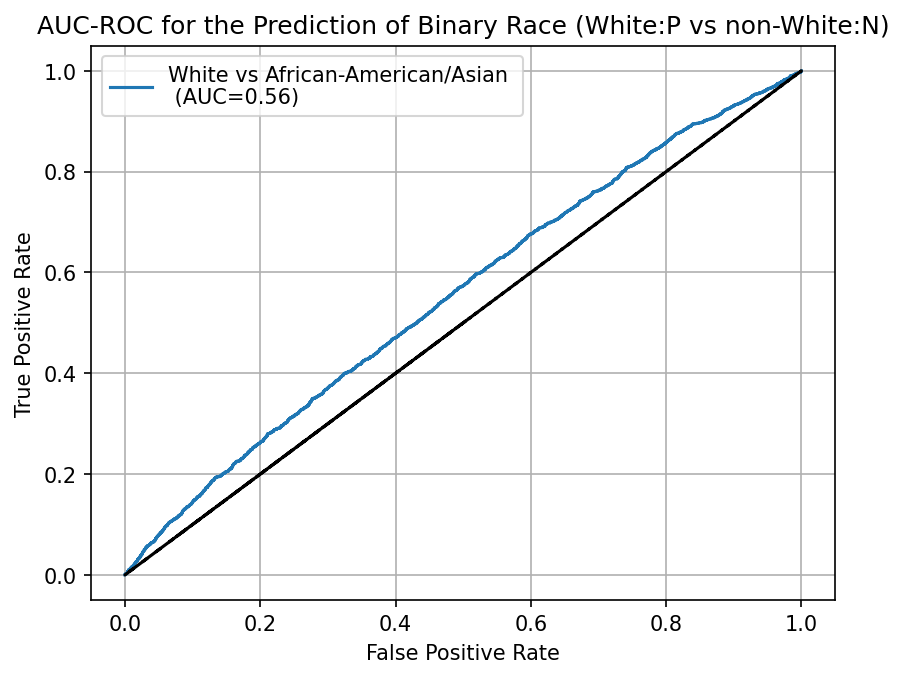

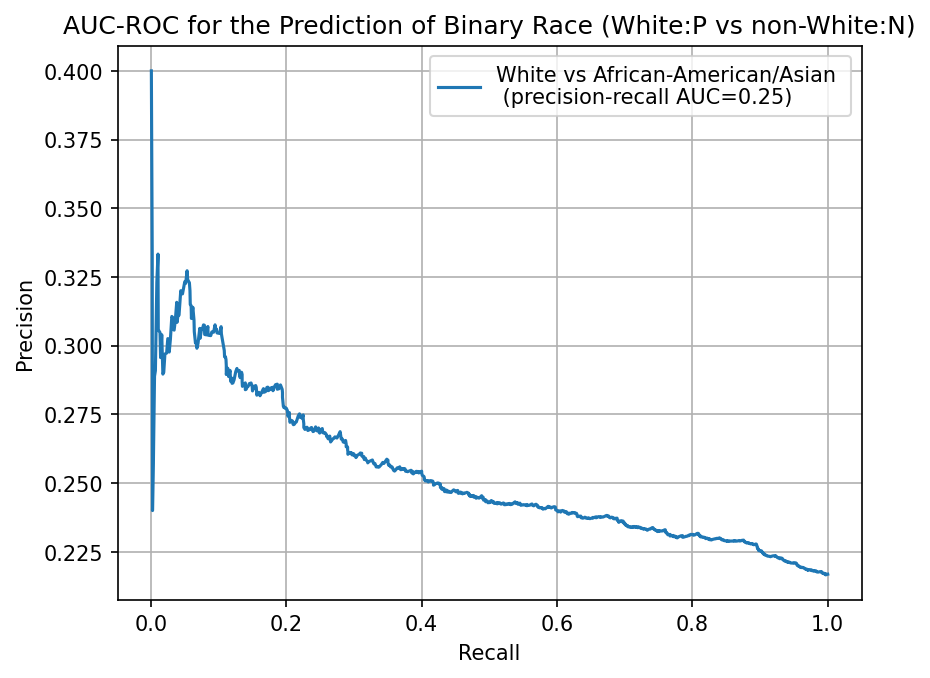

The optimum Threshold is: 0.54
              precision    recall  f1-score   support

         0.0       0.79      0.96      0.86      8484
         1.0       0.30      0.06      0.11      2349

    accuracy                           0.77     10833
   macro avg       0.55      0.51      0.49     10833
weighted avg       0.68      0.77      0.70     10833

[[8138  346]
 [2198  151]]


In [10]:
# chexpert age ful model eevaluated by NIH
name = 'chexpert_race_2_categ_segment_segment_1__'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_race__segment_1__belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))
y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])

AUC_ROC_Binary(y_true=y_chex_total,y_score=y_predict_chex_total)
AUC_Precision_Recall(y_true=y_chex_total,y_score=y_predict_chex_total)
threshold = prob2categ(y_chex_total,y_predict_chex_total)
print('The optimum Threshold is: {:.2f}'.format(threshold))
class_pred = y_predict_chex_total.copy()
class_pred[class_pred>threshold]=1
class_pred[class_pred<=threshold]=0
print(classification_report(y_true=y_chex_total, y_pred=class_pred))
cm = confusion_matrix(y_true=y_chex_total, y_pred=class_pred)
print(cm)

339/339 [==============================] - 0s 878us/step


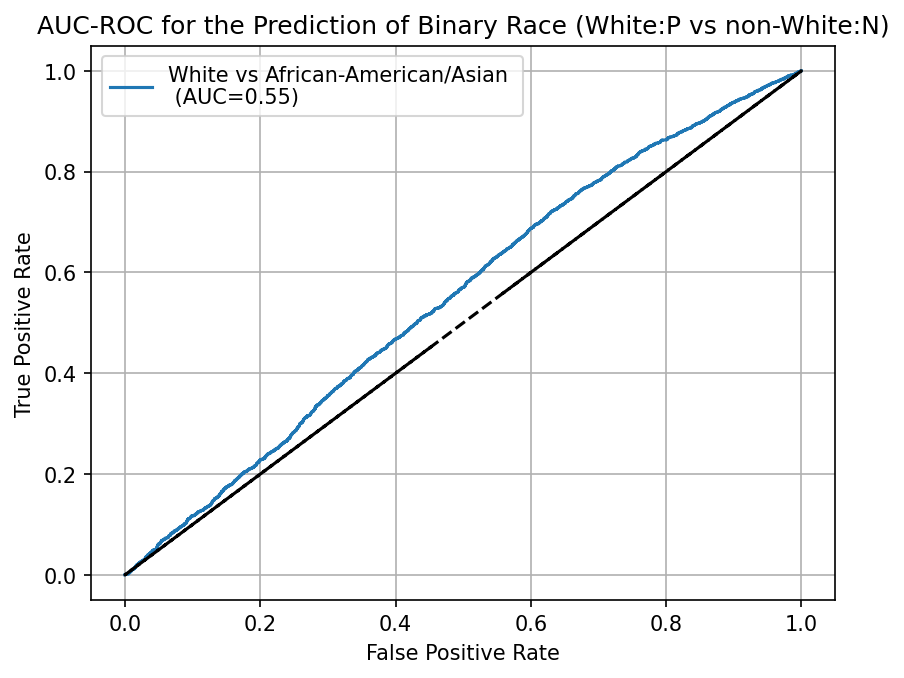

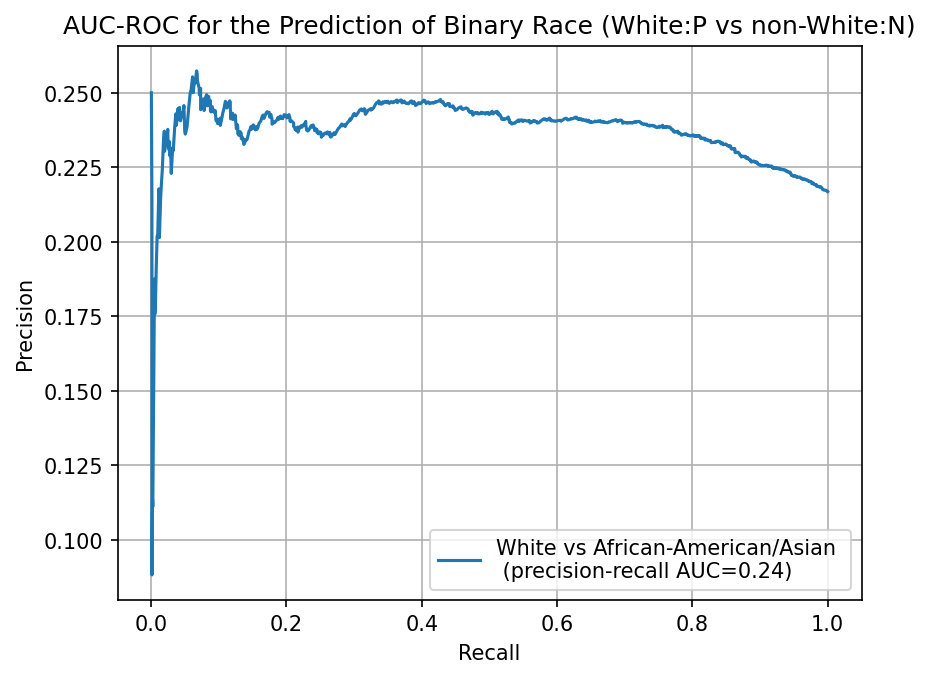

The optimum Threshold is: 0.54
              precision    recall  f1-score   support

         0.0       0.79      0.93      0.85      8484
         1.0       0.25      0.09      0.13      2349

    accuracy                           0.74     10833
   macro avg       0.52      0.51      0.49     10833
weighted avg       0.67      0.74      0.69     10833

[[7860  624]
 [2144  205]]


In [11]:
# chexpert age ful model eevaluated by NIH
name = 'chexpert_race_2_categ_segment_segment_2__'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_race__segment_2__belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))
y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])

AUC_ROC_Binary(y_true=y_chex_total,y_score=y_predict_chex_total)
AUC_Precision_Recall(y_true=y_chex_total,y_score=y_predict_chex_total)
threshold = prob2categ(y_chex_total,y_predict_chex_total)
print('The optimum Threshold is: {:.2f}'.format(threshold))
class_pred = y_predict_chex_total.copy()
class_pred[class_pred>threshold]=1
class_pred[class_pred<=threshold]=0
print(classification_report(y_true=y_chex_total, y_pred=class_pred))
cm = confusion_matrix(y_true=y_chex_total, y_pred=class_pred)
print(cm)

339/339 [==============================] - 0s 856us/step


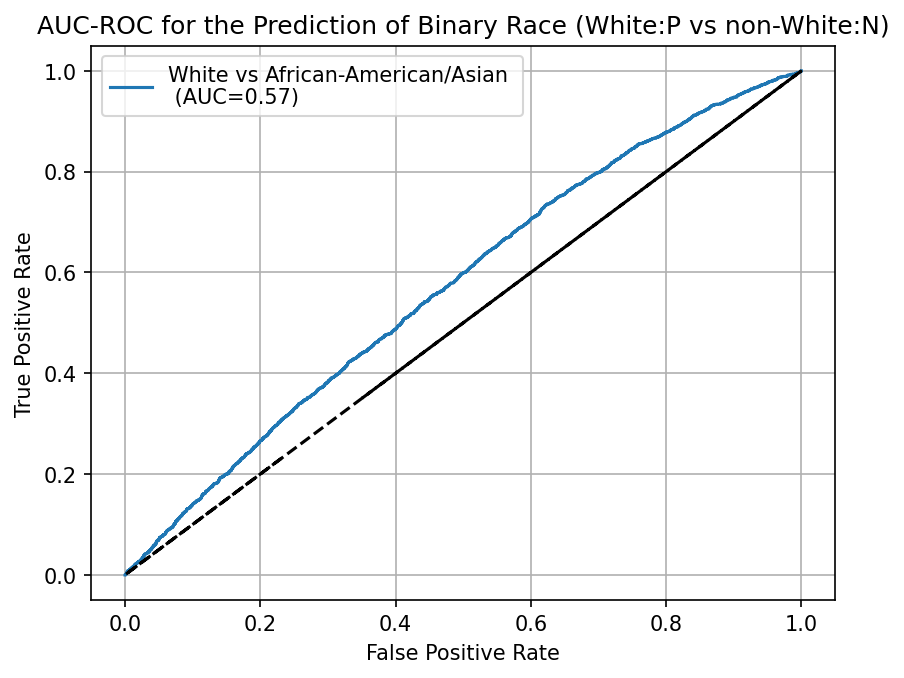

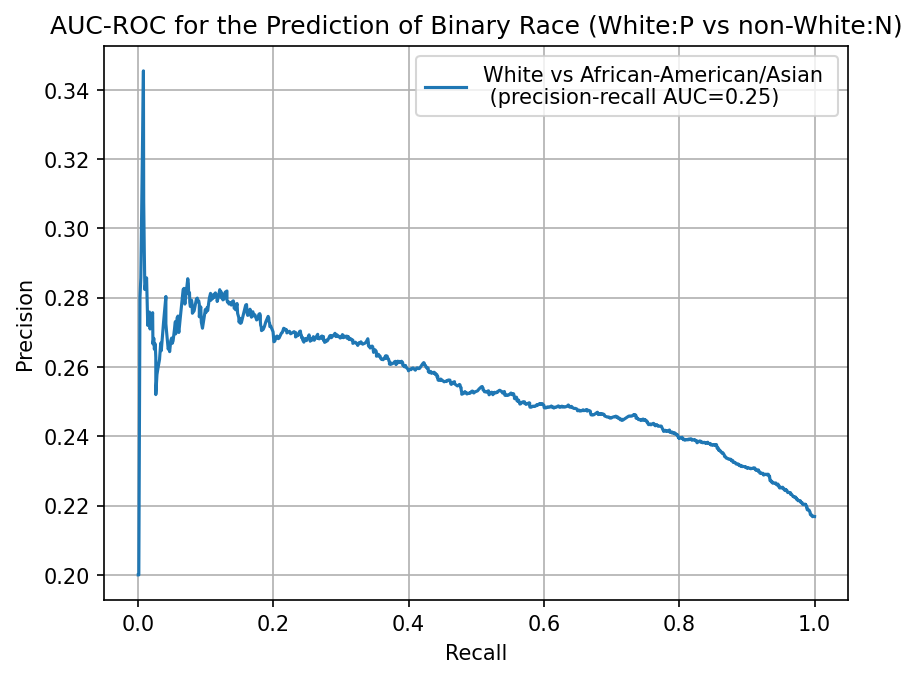

The optimum Threshold is: 0.55
              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85      8484
         1.0       0.28      0.11      0.16      2349

    accuracy                           0.74     10833
   macro avg       0.53      0.52      0.51     10833
weighted avg       0.68      0.74      0.70     10833

[[7801  683]
 [2083  266]]


In [12]:
# chexpert age ful model eevaluated by NIH
name = 'chexpert_race_2_categ_segment_segment_3__'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/mimic_race__segment_3__belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))
y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])

AUC_ROC_Binary(y_true=y_chex_total,y_score=y_predict_chex_total)
AUC_Precision_Recall(y_true=y_chex_total,y_score=y_predict_chex_total)
threshold = prob2categ(y_chex_total,y_predict_chex_total)
print('The optimum Threshold is: {:.2f}'.format(threshold))
class_pred = y_predict_chex_total.copy()
class_pred[class_pred>threshold]=1
class_pred[class_pred<=threshold]=0
print(classification_report(y_true=y_chex_total, y_pred=class_pred))
cm = confusion_matrix(y_true=y_chex_total, y_pred=class_pred)
print(cm)

253/253 [==============================] - 0s 1ms/step


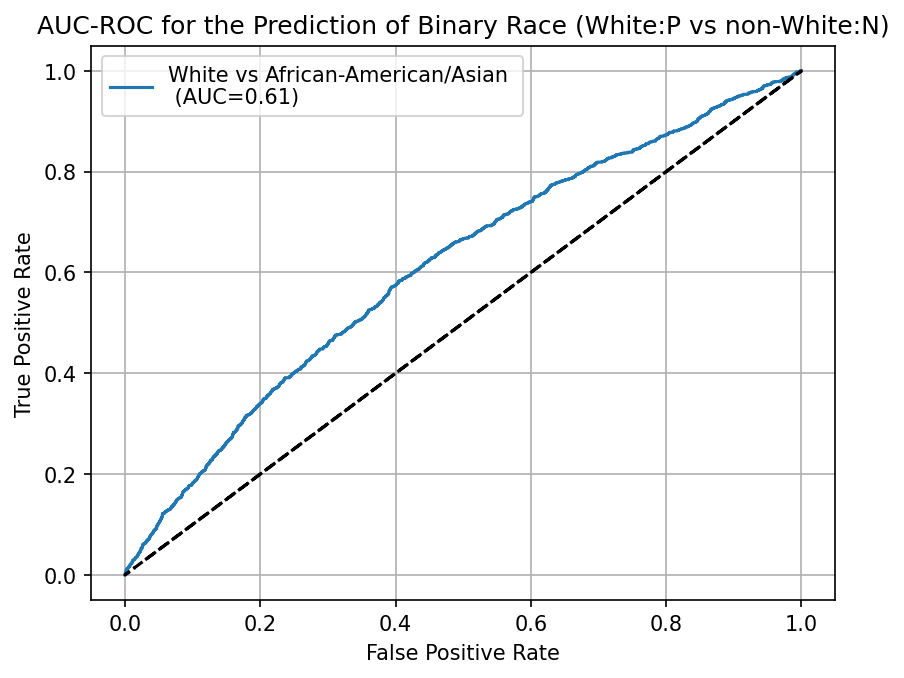

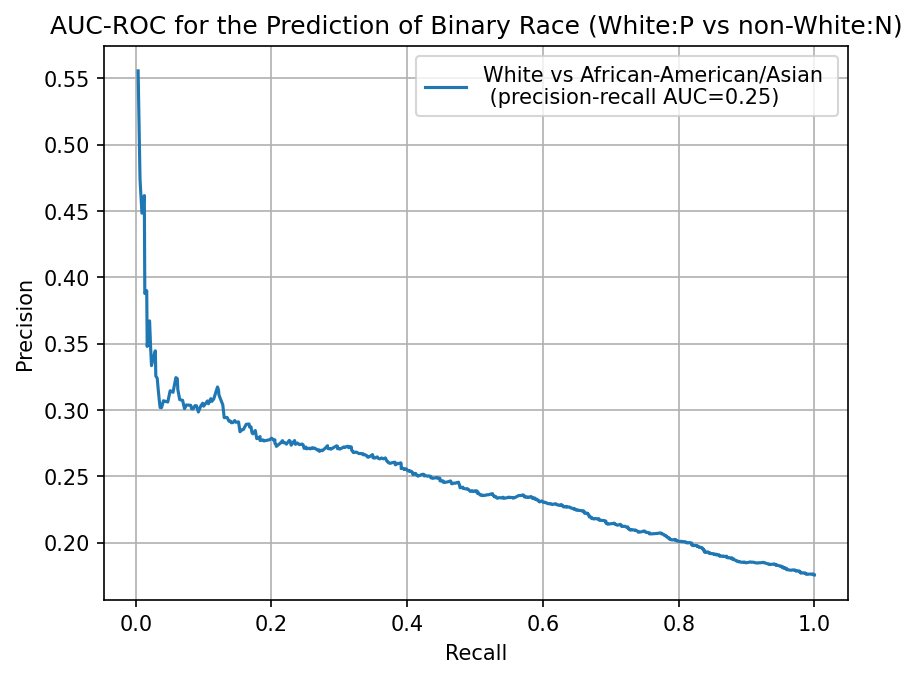

The optimum Threshold is: 0.59
              precision    recall  f1-score   support

         0.0       0.83      0.93      0.88      6662
         1.0       0.29      0.13      0.18      1419

    accuracy                           0.79      8081
   macro avg       0.56      0.53      0.53      8081
weighted avg       0.74      0.79      0.76      8081

[[6213  449]
 [1233  186]]


In [14]:
# chexpert age ful model eevaluated by NIH
name = 'mimic_race_full_'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_race_2_categ_full_belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))
y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])

AUC_ROC_Binary(y_true=y_chex_total,y_score=y_predict_chex_total)
AUC_Precision_Recall(y_true=y_chex_total,y_score=y_predict_chex_total)
threshold = prob2categ(y_chex_total,y_predict_chex_total)
print('The optimum Threshold is: {:.2f}'.format(threshold))
class_pred = y_predict_chex_total.copy()
class_pred[class_pred>threshold]=1
class_pred[class_pred<=threshold]=0
print(classification_report(y_true=y_chex_total, y_pred=class_pred))
cm = confusion_matrix(y_true=y_chex_total, y_pred=class_pred)
print(cm)

253/253 [==============================] - 0s 848us/step


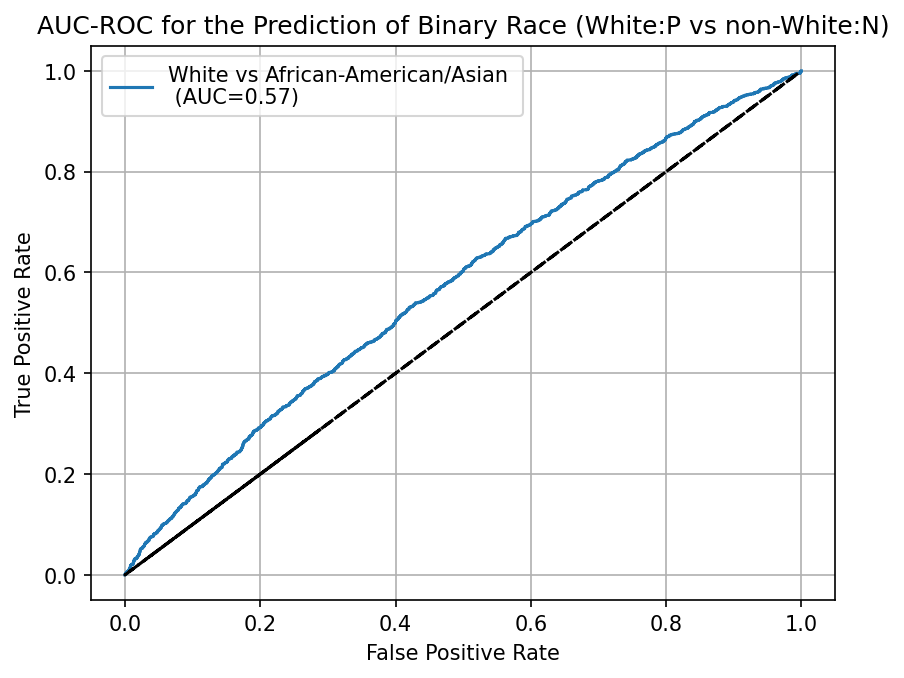

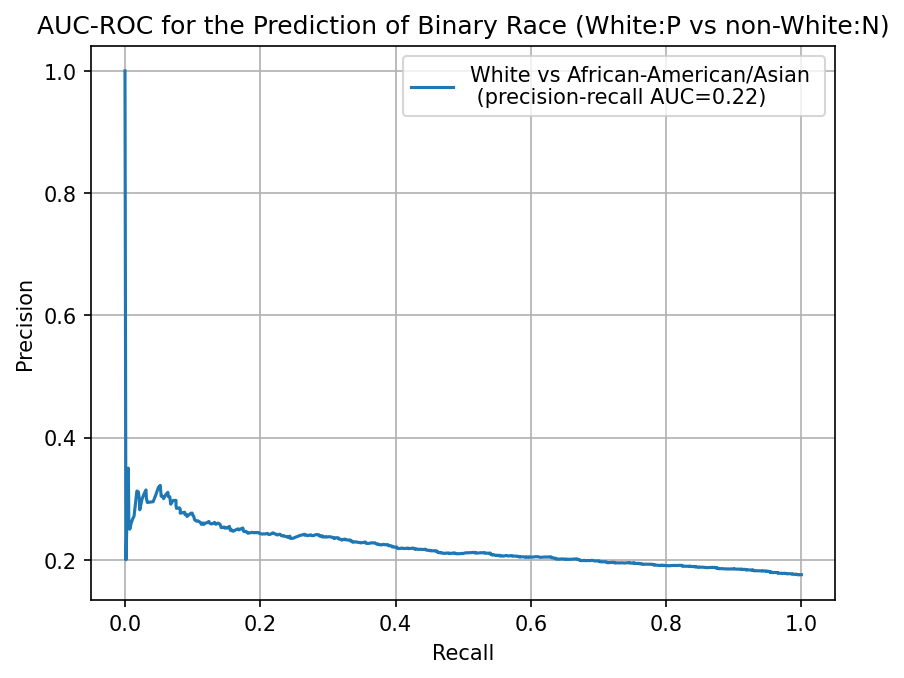

The optimum Threshold is: 0.55
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.89      6662
         1.0       0.27      0.09      0.14      1419

    accuracy                           0.80      8081
   macro avg       0.55      0.52      0.51      8081
weighted avg       0.73      0.80      0.75      8081

[[6309  353]
 [1286  133]]


In [15]:
# chexpert age ful model eevaluated by NIH
name = 'mimic_race__segment_0__'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_race_2_categ_segment_segment_0__belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))
y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])

AUC_ROC_Binary(y_true=y_chex_total,y_score=y_predict_chex_total)
AUC_Precision_Recall(y_true=y_chex_total,y_score=y_predict_chex_total)
threshold = prob2categ(y_chex_total,y_predict_chex_total)
print('The optimum Threshold is: {:.2f}'.format(threshold))
class_pred = y_predict_chex_total.copy()
class_pred[class_pred>threshold]=1
class_pred[class_pred<=threshold]=0
print(classification_report(y_true=y_chex_total, y_pred=class_pred))
cm = confusion_matrix(y_true=y_chex_total, y_pred=class_pred)
print(cm)

253/253 [==============================] - 0s 874us/step


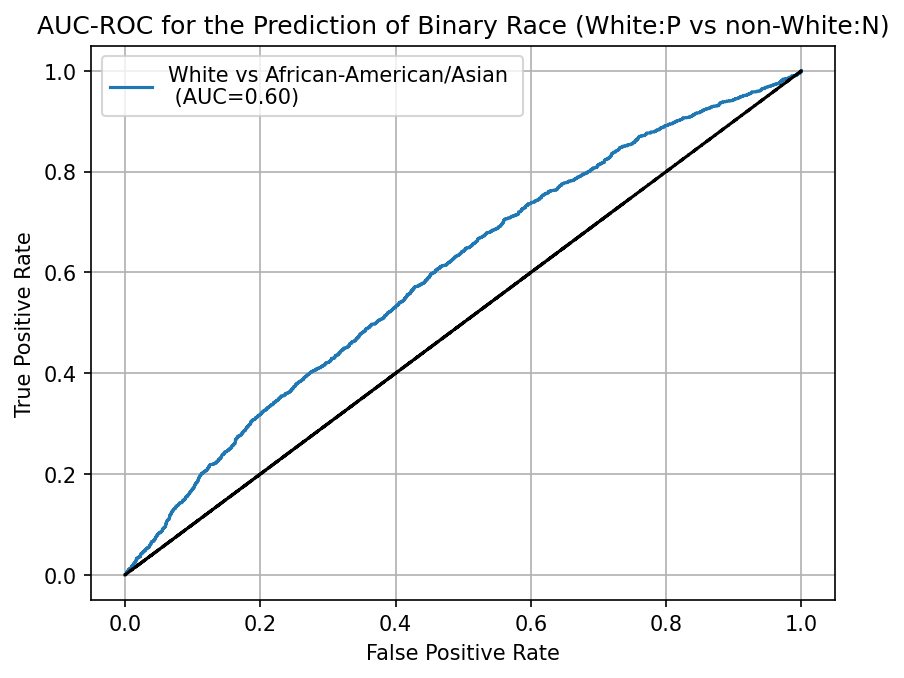

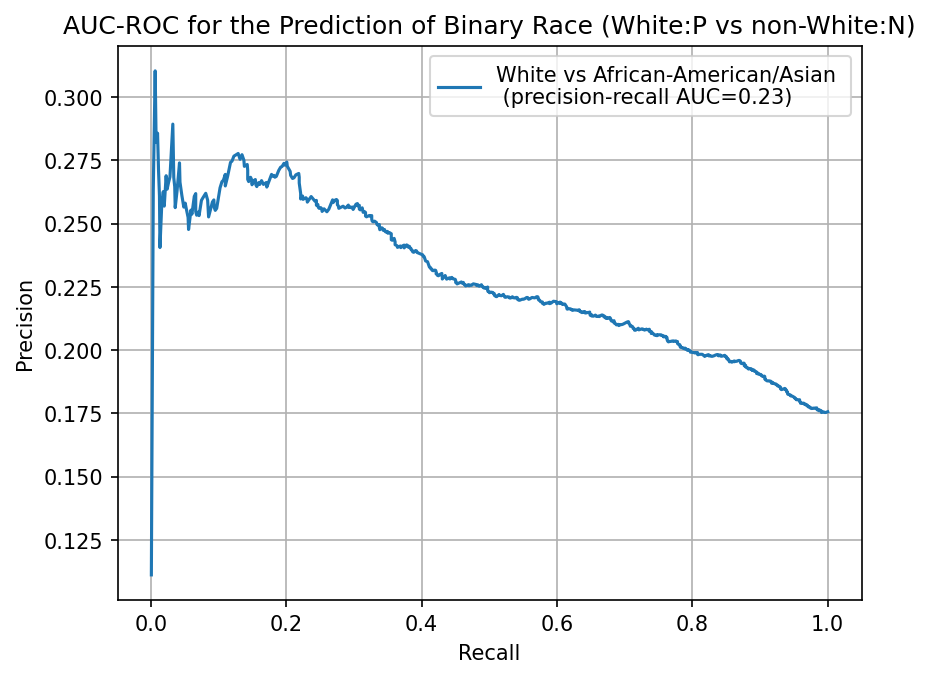

The optimum Threshold is: 0.57
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.89      6662
         1.0       0.26      0.08      0.12      1419

    accuracy                           0.80      8081
   macro avg       0.54      0.52      0.50      8081
weighted avg       0.73      0.80      0.75      8081

[[6347  315]
 [1309  110]]


In [16]:
# chexpert age ful model eevaluated by NIH
name = 'mimic_race__segment_1__'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_race_2_categ_segment_segment_1__belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))
y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])

AUC_ROC_Binary(y_true=y_chex_total,y_score=y_predict_chex_total)
AUC_Precision_Recall(y_true=y_chex_total,y_score=y_predict_chex_total)
threshold = prob2categ(y_chex_total,y_predict_chex_total)
print('The optimum Threshold is: {:.2f}'.format(threshold))
class_pred = y_predict_chex_total.copy()
class_pred[class_pred>threshold]=1
class_pred[class_pred<=threshold]=0
print(classification_report(y_true=y_chex_total, y_pred=class_pred))
cm = confusion_matrix(y_true=y_chex_total, y_pred=class_pred)
print(cm)

253/253 [==============================] - 0s 1ms/step


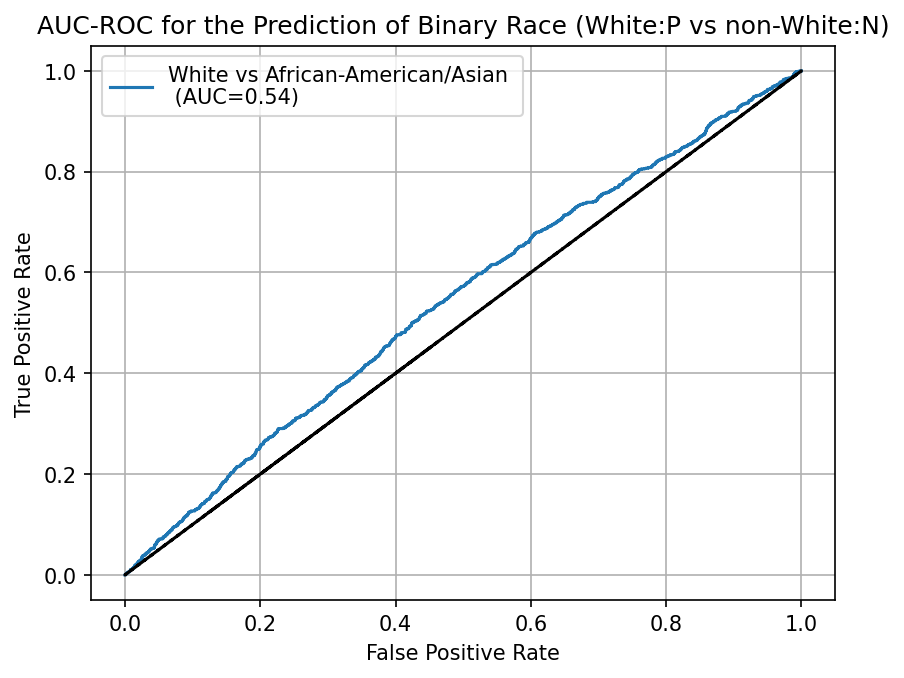

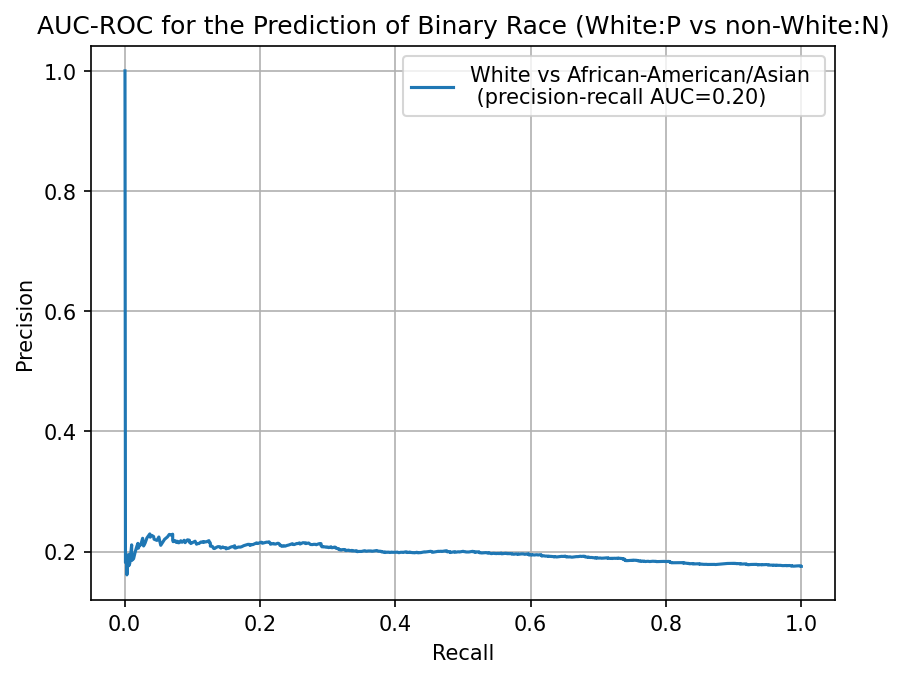

The optimum Threshold is: 0.54
              precision    recall  f1-score   support

         0.0       0.83      0.96      0.89      6662
         1.0       0.22      0.05      0.08      1419

    accuracy                           0.80      8081
   macro avg       0.52      0.51      0.49      8081
weighted avg       0.72      0.80      0.75      8081

[[6405  257]
 [1346   73]]


In [17]:
# chexpert age ful model eevaluated by NIH
name = 'mimic_race__segment_2__'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_race_2_categ_segment_segment_2__belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))
y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])

AUC_ROC_Binary(y_true=y_chex_total,y_score=y_predict_chex_total)
AUC_Precision_Recall(y_true=y_chex_total,y_score=y_predict_chex_total)
threshold = prob2categ(y_chex_total,y_predict_chex_total)
print('The optimum Threshold is: {:.2f}'.format(threshold))
class_pred = y_predict_chex_total.copy()
class_pred[class_pred>threshold]=1
class_pred[class_pred<=threshold]=0
print(classification_report(y_true=y_chex_total, y_pred=class_pred))
cm = confusion_matrix(y_true=y_chex_total, y_pred=class_pred)
print(cm)

253/253 [==============================] - 0s 837us/step


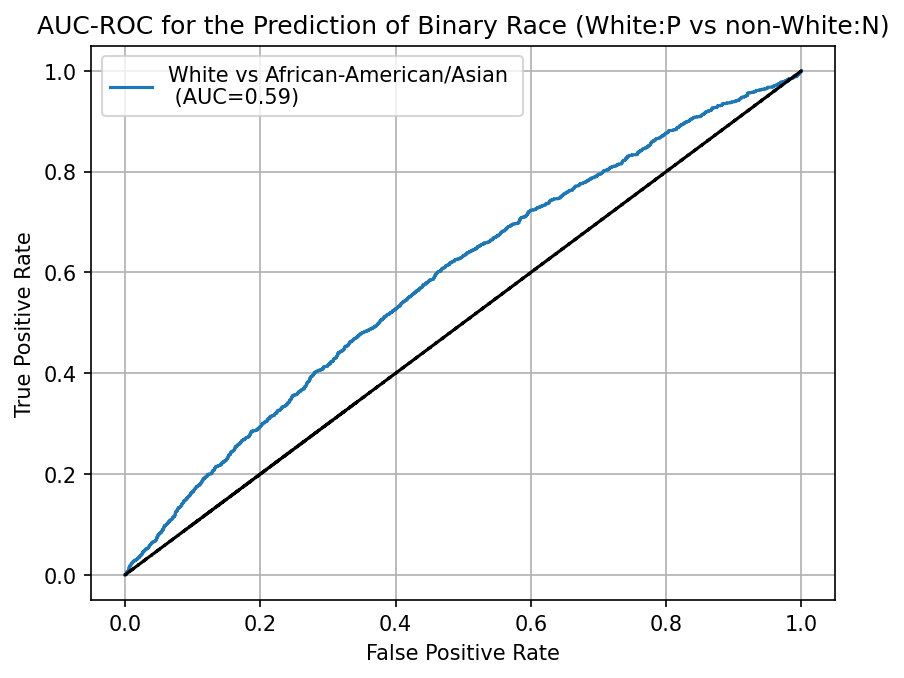

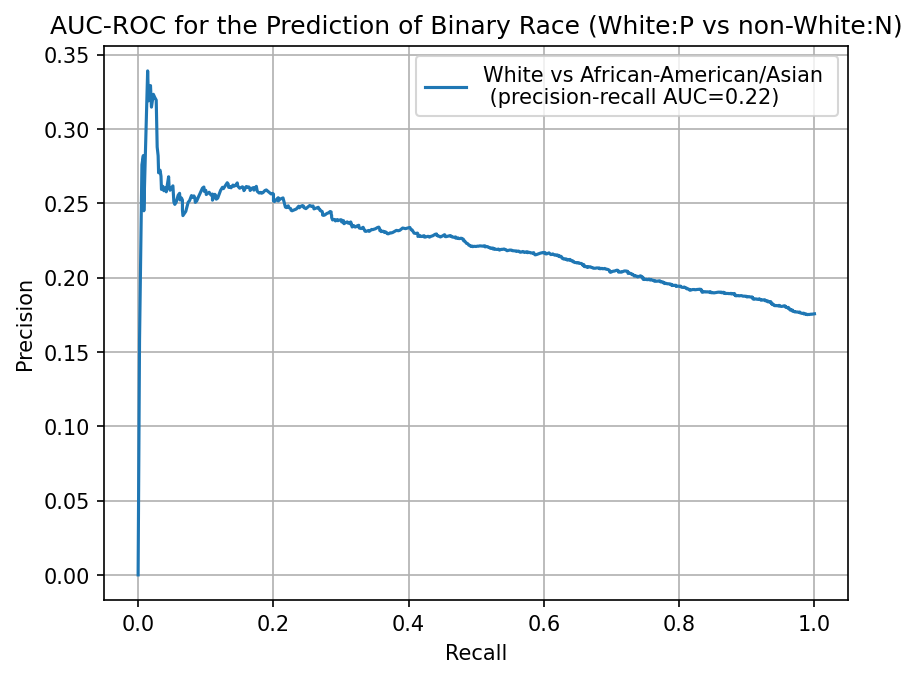

The optimum Threshold is: 0.57
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86      6662
         1.0       0.26      0.18      0.21      1419

    accuracy                           0.76      8081
   macro avg       0.55      0.53      0.54      8081
weighted avg       0.73      0.76      0.75      8081

[[5923  739]
 [1165  254]]


In [18]:
# chexpert age ful model eevaluated by NIH
name = 'mimic_race__segment_3__'
model_chex_total = load_model(name + '_mdl.h5')  # loading the chexpert model
test_data = np.load('/Users/mra/Desktop/results/age_chexpert/chexpert_race_2_categ_segment_segment_3__belongings.npy',allow_pickle=True).item()  # loading the NIH test data
x_chex_total = test_data['x_test'] # nih x test
y_chex_total = test_data['y_test'] # nih y test

mask = np.load(name + 'belongings.npy',allow_pickle=True).item()  # loadnig the chexpert data
mask_chex_total = mask['mask_excluded'] # loading the chexpert masks

#===================================
original_x = x_chex_total * np.tile(test_data['std'].reshape((1,-1)),reps=(x_chex_total.shape[0],1)) + np.tile(test_data['mean'].reshape((1,-1)),reps=(x_chex_total.shape[0],1))
x =  (original_x-np.tile(mask['mean'].reshape((1,-1)),reps=(original_x.shape[0],1)))/np.tile(mask['std'].reshape((1,-1)),reps=(original_x.shape[0],1))
y_predict_chex_total = model_chex_total.predict(x[:,mask_chex_total])

AUC_ROC_Binary(y_true=y_chex_total,y_score=y_predict_chex_total)
AUC_Precision_Recall(y_true=y_chex_total,y_score=y_predict_chex_total)
threshold = prob2categ(y_chex_total,y_predict_chex_total)
print('The optimum Threshold is: {:.2f}'.format(threshold))
class_pred = y_predict_chex_total.copy()
class_pred[class_pred>threshold]=1
class_pred[class_pred<=threshold]=0
print(classification_report(y_true=y_chex_total, y_pred=class_pred))
cm = confusion_matrix(y_true=y_chex_total, y_pred=class_pred)
print(cm)